# United States Mutual Funds Analysis

### Objective:
This Jupyter notebook has been prepared to explore the following 3 questions related to mutual funds in the United States
1. Is the fund expense ratio an important factor for selecting funds that will generate the best performance
2. What are the most popular top holdings of the best performing mutual funds
3. Can the (i) Morningstar return rating, (ii) 5 year average fund performance, (iii) investment style and (iv) size type, be used to predict current performance

### Table of Content<a name="itemA"></a>


1. <a href="#item1">Import required libraries and dataset</a>
2. <a href="#item2">Explore categorical variables</a>
3. <a href="#item3">Dropping columns with the most missing values</a>
4. <a href="#item4">Question No. 1: Fund return and fund expense ratios</a>
5. <a href="#item5">Question No. 2: Top holdings in best performing funds</a>
6. <a href="#item6">Question No. 3: Predicting fund performance</a>
    * 6a. <a href="#item6a">Convert investment type and size type from categorical to numeric variable</a>
    * 6b. <a href="#item6b">Imputation for fund_mean_annual_return_5years</a>
    * 6c. <a href="#item6d">Imputation for the morningstar_return_rating variable</a>
    * 6d. <a href="#item6d">Build and test the model</a>
    * 6e. <a href="#item6e">Conclusion</a>
    


## 1. Import required libraries and dataset<a name="item1"></a>
<a href="#itemA">*`Table of content`*</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

%matplotlib inline

df = pd.read_csv('MutualFunds.csv')

print("There are {} rows and {} columns in the dataset".format(df.shape[0], df.shape[1]))
      
df.head(3)

There are 23783 rows and 298 columns in the dataset


,fund_symbol,quote_type,region,fund_short_name,fund_long_name,currency,initial_investment,subsequent_investment,fund_category,fund_family,...,peer_environment_avg,peer_environment_max,social_score,peer_social_min,peer_social_avg,peer_social_max,governance_score,peer_governance_min,peer_governance_avg,peer_governance_max
0,AAAAX,MutualFund,US,DWS RREEF Real Assets Fund - Cl,DWS RREEF Real Assets Fund - Class A,USD,1000.0,50.0,World Allocation,DWS,...,5.05,10.58,7.43,5.98,9.07,11.30,5.43,4.26,7.14,8.11
1,AAAEX,MutualFund,US,AllianzGI Health Sciences Fund,Virtus AllianzGI Health Sciences Fund Class P,USD,1000000.0,NaN,Health,Virtus,...,1.43,3.27,12.96,9.52,12.87,15.08,8.40,4.96,7.68,10.30
2,AAAFX,MutualFund,US,NaN,American Century One Choice Blend+ 2015 Portfo...,USD,2500.0,50.0,Target-Date 2015,American Century Investments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##  2. Explore categorical variables<a name="item2"></a>
<a href="#itemA">*`Table of content`*</a>

In [2]:
# identify non-numeric/categorical columns

cat_cols = df.select_dtypes(include='object')
cat_cols.columns

Index(['fund_symbol', 'quote_type', 'region', 'fund_short_name',
       'fund_long_name', 'currency', 'fund_category', 'fund_family',
       'exchange_code', 'exchange_name', 'exchange_timezone',
       'management_name', 'management_bio', 'management_start_date',
       'investment_strategy', 'inception_date', 'investment_type', 'size_type',
       'top10_holdings', 'returns_as_of_date', 'esg_peer_group'],
      dtype='object')

In [3]:
# instantiate list of columns to be deleted
cols_to_delete = []

# identify categorical columns to delete

for col in cat_cols:
    
    # count the number of unique values for categorical values and print result for each column
    value = df[col].nunique()
    print(col, value)        
    
    # identify columns with only 1 value i.e. value == 1
    # or with unique values in each column i.e. value equals total number of rows (value == df.shape[0])
    # such columns are not useful for further analysis and can be removed from the dataset
    
    if value == 1 or value == df.shape[0]:
        cols_to_delete.append(col) 
        
    # the information about management and the date columns are not considered necessary
    # add the columsn to the list of columns to be deleted

    if col in df.filter(regex='management').columns.tolist() or col in df.filter(regex='date').columns.tolist():
        cols_to_delete.append(col) 
        
print("\n The following columns can be deleted: \n", cols_to_delete)
          

fund_symbol 23783
quote_type 1
region 1
fund_short_name 3044
fund_long_name 6644
currency 1
fund_category 119
fund_family 310
exchange_code 1
exchange_name 1
exchange_timezone 1
management_name 1388
management_bio 1300
management_start_date 2316
investment_strategy 2245
inception_date 4499
investment_type 3
size_type 3
top10_holdings 2347
returns_as_of_date 51
esg_peer_group 86

 The following columns can be deleted: 
 ['fund_symbol', 'quote_type', 'region', 'currency', 'exchange_code', 'exchange_name', 'exchange_timezone', 'management_name', 'management_bio', 'management_start_date', 'inception_date', 'returns_as_of_date']


In [4]:
# drop columns not considered useful for further analysis
df1 = df.drop(cols_to_delete, axis=1)

# display remaining categorical variables
cat_cols = df1.select_dtypes(include='object').columns
cat_cols

Index(['fund_short_name', 'fund_long_name', 'fund_category', 'fund_family',
       'investment_strategy', 'investment_type', 'size_type', 'top10_holdings',
       'esg_peer_group'],
      dtype='object')

In [5]:
df1['fund_category'].value_counts()

Large Blend                     1235
Large Growth                    1172
Large Value                     1080
Diversified Emerging Mkts        741
Foreign Large Blend              680
                                ... 
Miscellaneous Sector               4
Trading--Inverse Commodities       4
World Large-Stock Growth           1
Market Neutral                     1
Long-Short Credit                  1
Name: fund_category, Length: 119, dtype: int64

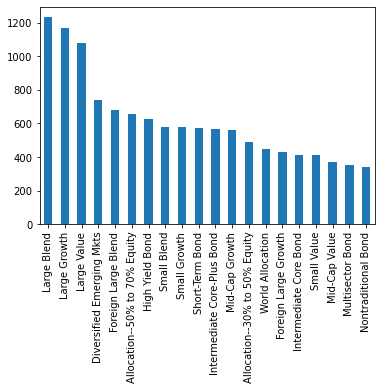

In [6]:
df1['fund_category'].value_counts()[:20].plot(kind='bar');

In [7]:
df1['investment_type'].value_counts()

Blend     10902
Value      6847
Growth     4925
Name: investment_type, dtype: int64

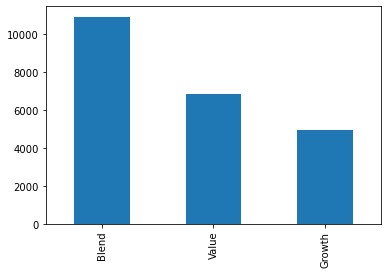

In [8]:
df1['investment_type'].value_counts().plot(kind='bar');

In [9]:
df1['size_type'].value_counts()

Large     13199
Medium     5582
Small      3893
Name: size_type, dtype: int64

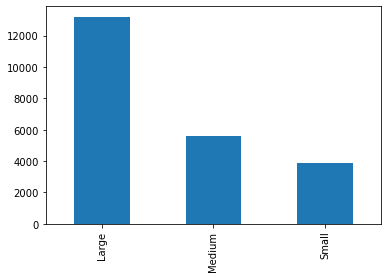

In [10]:
df1['size_type'].value_counts().plot(kind='bar');

In [11]:
df1['esg_peer_group'].value_counts()

US Fund Large Growth                            1209
US Fund Large Blend                             1146
US Fund Large Value                             1031
US Fund World Large Stock                        815
US Fund Diversified Emerging Mkts                699
                                                ... 
US Fund Long-Term Bond                             2
US Fund Bear Market                                1
US Fund Emerging-Markets Local-Currency Bond       1
US Fund Short Government                           1
US Fund Miscellaneous Sector                       1
Name: esg_peer_group, Length: 86, dtype: int64

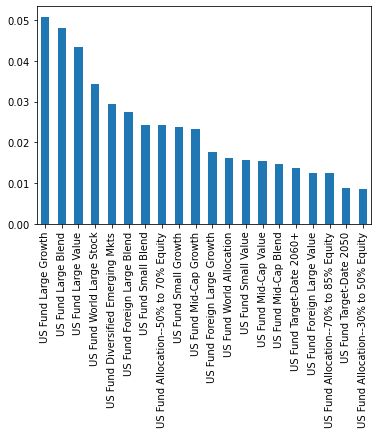

In [12]:
(df1['esg_peer_group'].value_counts()[:20]/df1.shape[0]).plot(kind='bar');

In [13]:
# print the value in the first row of the 'investment_strategy' column and display first 5 rows
print(df1['investment_strategy'][0])
df1['investment_strategy'].head()

The investment seeks total return in excess of inflation through capital growth and current income. The fund will invest at least 80% of its net assets, plus the amount of any borrowings for investment purposes, in a combination of investments that the Advisor believes offer exposure to "real assets." It generally invests between 25% and 75% of fund assets in securities of foreign issuers, including up to 10% of fund assets in issuers located in countries with new or emerging markets.


0    The investment seeks total return in excess of...
1    The investment seeks long-term capital appreci...
2    The investment seeks the highest total return ...
3    The investment seeks long-term capital appreci...
4    The investment seeks the highest total return ...
Name: investment_strategy, dtype: object

The `investment_strategy` column is a full description of the strategy which does lend itself to futher analysis in a simple way and can be dropped

In [14]:
df1.drop('investment_strategy', axis=1, inplace=True)

## 3. Dropping columns with the most missing values<a name="item3"></a>
<a href="#itemA">*`Table of content`*</a>


In [15]:
#Generate a list of columns with more than 50% of the values missing

most_missing_cols = df1.columns[df1.isnull().mean() > 0.50]
print(len(most_missing_cols))
most_missing_cols

73


Index(['subsequent_investment', 'last_cap_gain', 'fund_max_12b1_fee',
       'fund_max_front_end_sales_load', 'fund_max_deferred_sales_load',
       'fund_bond_maturity', 'fund_bond_duration', 'fund_bonds_us_government',
       'fund_bonds_aaa', 'fund_bonds_aa', 'fund_bonds_a', 'fund_bonds_bbb',
       'fund_bonds_bb', 'fund_bonds_b', 'fund_bonds_below_b',
       'fund_bonds_others', 'fund_return_2010', 'fund_return_2009',
       'fund_return_2008', 'fund_return_2007', 'fund_return_2006',
       'fund_return_2005', 'fund_return_2004', 'fund_return_2003',
       'fund_return_2002', 'fund_return_2001', 'fund_return_2000',
       'fund_return_2021_q3', 'fund_return_2021_q2', 'fund_return_2010_q4',
       'fund_return_2010_q3', 'fund_return_2010_q2', 'fund_return_2010_q1',
       'fund_return_2009_q4', 'fund_return_2009_q3', 'fund_return_2009_q2',
       'fund_return_2009_q1', 'fund_return_2008_q4', 'fund_return_2008_q3',
       'fund_return_2008_q2', 'fund_return_2008_q1', 'fund_return_20

The columns with half (50%) or more missing values include sales load measures (fund_max_12b1_fee', 'fund_max_front_end_sales_load', 'fund_max_deferred_sales_load'). Our analysis will mostly be focused on return and risk measures hence these columsn can be dropped.

The fund and return data for 2000 to 2010 and quarterly returns for 2021 also appear in the list of most missing columns. We can also drop these columns as the dataset includes return data for the years 2011 to 2020 which is of more relevant since this is 10 years of the most recent return data. All quarterly returns can also be dropped as the focus will be on annual measures.

Also included are columns that apply only to credit funds i.e columns with the prefix "fund_bonds_". As our analysis will not be focused on credit specific measures we can also drop these columns  

In [16]:
# drop columns with 50% or more missing values

df1.drop(most_missing_cols, axis=1, inplace=True)

# drop all other quarterly returns columns i.e. columns with the suffix '_q'

df1.drop(df1.filter(regex='_q').columns.tolist(), axis=1, inplace=True)

df1.shape

(23783, 171)

## 4. Question No. 1: Fund Return and Fund Expense Ratios<a name="item4"></a>
<a href="#itemA">*`Table of content`*</a>


Question 1 - Is the expense ratio a good factor to consider when seeking to select funds that generate the best return.

One of the common pieces of advice that retail investors are given for selecting funds to invest in is to consider funds with a low expense ratio. In this section I will explore if the data really support the theory that a low expense ratio is a good proxy for selecting funds that will generate good performance.

C:\Users\E041938\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


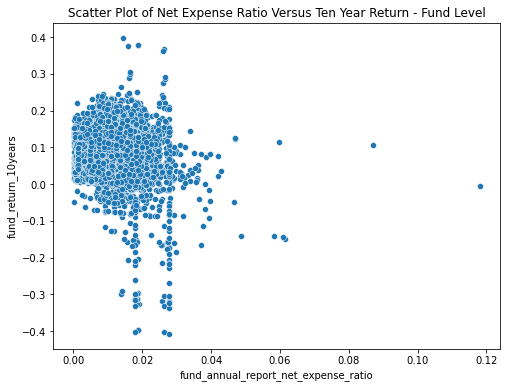

In [17]:
# Visualize the relationship between expense ration and fund return using a scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot('fund_annual_report_net_expense_ratio', 'fund_return_10years', data=df1)
plt.title('Scatter Plot of Net Expense Ratio Versus Ten Year Return - Fund Level');

In [18]:
# the visual above did not suggest a strong correlation 
# we can confirm this by calculating the correlation statistic using the corr() function in pandas

df1[['fund_annual_report_net_expense_ratio', 'fund_return_10years']].corr()

,fund_annual_report_net_expense_ratio,fund_return_10years
fund_annual_report_net_expense_ratio,1.00000,-0.07102
fund_return_10years,-0.07102,1.00000


A score close to zero as per the correlation matrix above suggests there is a very weak correlation which is consistent with what we observed in the scatterplot.

However, the above observation was made using the overall population. Perhaps the expense ratio is more meaningful when an investor is making a decision about which fund category to invest in. Is it possible that this relationship can be used to  narrow down the selection of a given fund category amongst the different fund caegories. 

We will next explore if the expense ratio may be more meaningful when examined at the fund category level

In [19]:
groupby_dict = {'category_return_10years':np.mean, 
                'fund_return_10years':np.mean, 
                'fund_annual_report_net_expense_ratio':np.mean,
                'category_annual_report_net_expense_ratio':np.mean}

df1_grouped_cat = df1.groupby('fund_category').agg(groupby_dict)

df1_grouped_cat.head()


,category_return_10years,fund_return_10years,fund_annual_report_net_expense_ratio,category_annual_report_net_expense_ratio
fund_category,,,,
Allocation--15% to 30% Equity,0.046810,0.048898,0.009908,0.0064
Allocation--30% to 50% Equity,0.060207,0.063869,0.010247,0.0072
Allocation--50% to 70% Equity,0.081517,0.086709,0.010839,0.0084
Allocation--70% to 85% Equity,0.086611,0.091766,0.010948,0.0070
Allocation--85%+ Equity,0.097900,0.106694,0.012530,0.0073


C:\Users\E041938\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


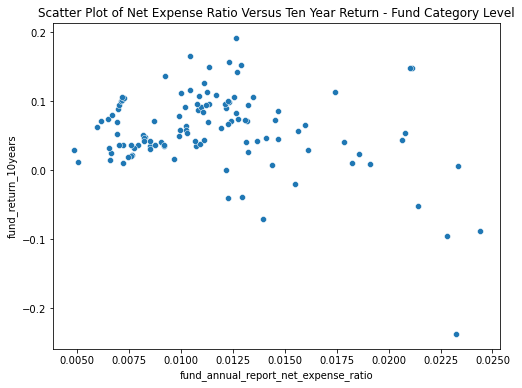

In [20]:
# Visualize the relationship between expense ratio and fund return using a scatter plot
plt.figure(figsize=(8,6))

sns.scatterplot('fund_annual_report_net_expense_ratio', 'fund_return_10years', data=df1_grouped_cat)
plt.title('Scatter Plot of Net Expense Ratio Versus Ten Year Return - Fund Category Level');

The visual above suggests that the relationship between performance and the expense ratio strengthens when using the the mean returns and expense ratio at the fund category level. 

In [21]:
# we can confirm this by calculating the correlation statistic using the corr() function in pandas

df1_grouped_cat[['fund_annual_report_net_expense_ratio', 'fund_return_10years']].corr()

,fund_annual_report_net_expense_ratio,fund_return_10years
fund_annual_report_net_expense_ratio,1.00000,-0.27154
fund_return_10years,-0.27154,1.00000


Although the correlation is still fairly weak, it appears to be more relevant when comparing different fund categories. We can conclude that the relationship between expense ratio and fund return may have limited use for selecting the fund category to focus. 

We can explore this further by identifying the top 5 categories that on average outperform and also have low expense ratios

First we create a function to identify the funds that outperform their average return for their category and those that underperform. We do this using a function called `outperform_category` as shown below:

In [22]:
def outperform_category(df):
    '''
    INPUT
        Dataframe with the following columns:
        1. fund_return_10years - column for each fund's 10 year return
        2. category_return_10years - column for the 10 year return of the category to which a fund belongs 
    OUTPUT
        return 1 if the fund_return_10years is greater than category_return_10years
        rturn -1 if the the fund does not have a value in the fund_return_10years columm
        return 0 otherwise
    
    '''
    if df['fund_return_10years'] > df['category_return_10years']:
        return 1
    elif np.isnan(df['fund_return_10years']):
        return -1
    else:
        return 0
    

# Create column that indentfies fund which outperform (1) or underperforms(0) the category return
# or have no fund 10 year return (-1)

df1['outperforms_category'] = df1[['fund_return_10years', 'category_return_10years']].apply(outperform_category, axis=1)

outperform = df1[df1['outperforms_category'] == 1] # Subset df to only those with HigherEd of 1
underperform = df1[df1['outperforms_category'] == 0] # Subset df to only those with HigherEd of 0

print(outperform ['outperforms_category'][:5]) #Assure it looks like what you would expect
print(underperform['outperforms_category'][:5]) #Assure it looks like what you would expect

0     1
3     1
5     1
14    1
15    1
Name: outperforms_category, dtype: int64
12    0
13    0
29    0
39    0
41    0
Name: outperforms_category, dtype: int64


Next we calculate the proportion of funds in each category that outperform the average for their category and those that underperform. We use the function `perform_pct` to calculate these proportions. 

We call this function to create the dataframe `cat_perform_df` which stores the outperformance and underperformance proportions by category

In [23]:
def perform_pct(df):    
    performance = df['fund_category'].value_counts().reset_index()
    performance.rename(columns={'index': 'category', 'fund_category': 'count'}, inplace=True)
    performance_df = defaultdict(int)
    
    #loop through list of fund categories    
    for val in performance['category'].unique().tolist():
        #loop through rows
        for idx in range(performance.shape[0]):
            #if the fund category is in the row add 1
            if val in performance['category'][idx]:
                performance_df[val] += int(performance['count'][idx])
                
    performance_df = pd.DataFrame(pd.Series(performance_df)).reset_index()
    performance_df.columns = ['category', 'count']
    performance_df.sort_values('count', ascending=False, inplace=True)
    performance_df.set_index('category', inplace=True)
    
    return performance_df/performance_df.sum()
    
outperform_pct = perform_pct(outperform)
underperform_pct = perform_pct(underperform)

cat_perform_df = pd.merge(outperform_pct, underperform_pct, left_index=True, right_index=True)
cat_perform_df.columns = ['outperform_perc', 'underperform_perc']
cat_perform_df['Performance_Difference'] = cat_perform_df['outperform_perc'] - cat_perform_df['underperform_perc']
cat_perform_df.sort_values(by='Performance_Difference', axis = 0, ascending=False, inplace=True)


In [24]:
# top 5 most outperforming strategies that also have lower expense ratios on average

cat_perform_df[:5].style.bar(subset=['Performance_Difference'], align='mid', color=['#d65f5f', '#5fba7d'])

,outperform_perc,underperform_perc,Performance_Difference
category,,,
Large Blend,0.098209,0.066154,0.032055
Large Growth,0.083217,0.054808,0.028409
Mid-Cap Growth,0.036844,0.011538,0.025306
Real Estate,0.022615,0.008846,0.013769
Small Growth,0.031762,0.021731,0.010031


## 5. Question No. 2: Top holdings in best performing funds<a name="item5"></a>
<a href="#itemA">*`Table of content`*</a>

In [25]:
# let's take a loot at what state the top10_holdings column is currently in
df1.top10_holdings

0        "Cayman Real Assets Fund Ltd.": 0.1098, CCI ("...
1        AZN. L ("AstraZeneca PLC ADR"): 0.0585, MDT ("...
2        AVBNX ("Avantis© Core Fixed Income G"): 0.2708...
3        AMZN ("Amazon.com Inc"): 0.1102, MSFT ("Micros...
4        AVBNX ("Avantis© Core Fixed Income G"): 0.2708...
                               ...                        
23778    SBNY ("Signature Bank"): 0.0213, FBC ("Flagsta...
23779    "Capital Group Central Cash Fund": 0.0499, "Ja...
23780    MSFT ("Microsoft Corp"): 0.0334, AVGO ("Broadc...
23781    00700 ("Tencent Holdings Ltd"): 0.1334, 09988 ...
23782    ROP ("Roper Technologies Inc"): 0.0984, HON ("...
Name: top10_holdings, Length: 23783, dtype: object

We won't be able to use this field in its current form and will need to split it into 10 separate columns to hold each of the top 10 holdings for each respective fund

In [26]:
# get extract of dataset with only the rows that have a value in the top10_holdings columns 
df_top = df1[df1.top10_holdings.isnull() == False]

# create list with column names for each of the top 10 holdings
cols = ['top_1', 'top_2', 'top_3', 'top_4', 'top_5', 'top_6', 'top_7', 'top_8', 'top_9', 'top_10']

# lambda function to split top10_holdings column into a series of lists containing the top 10 holdings
# the function uses regular expression to extract the text in between double quotes based on the pattern observed
split_top10 = lambda row: re.findall('"([^"]*)"', row)

# apply function to create a series of lists of each rows top 10 holdings
top10 = df_top['top10_holdings'].apply(split_top10).tolist()

# some rows do not have 10 holdings. This loop will append nans to ensure each list has 10 values
for top in top10:
    top_len = 10 - len(top)
    while top_len > 0:
        top.append(np.nan)
        top_len = top_len - 1

# convert the series of list into a dataframe (df_temp) and join this to the df_top dataframe
df_temp = pd.DataFrame(top10, columns=cols)
df_top = df_top.join(df_temp)

# check result of the combined dataframe
df_top.head()


,fund_short_name,fund_long_name,initial_investment,fund_category,fund_family,total_net_assets,year_to_date_return,day50_moving_average,day200_moving_average,week52_high_low_change,...,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
0,DWS RREEF Real Assets Fund - Cl,DWS RREEF Real Assets Fund - Class A,1000.0,World Allocation,DWS,2.979347e+09,0.21026,12.788,12.369,2.44,...,Cayman Real Assets Fund Ltd.,Crown Castle International Corp,Cheniere Energy Inc,United States Treasury Notes 1.62%,Freeport-McMoRan Inc,United States Treasury Notes 0.12%,American Tower Corp,Williams Companies Inc,Lme Pri Alum Futr Jul21 Xlme 20210719,NaN
1,AllianzGI Health Sciences Fund,Virtus AllianzGI Health Sciences Fund Class P,1000000.0,Health,Virtus,1.953489e+08,0.19077,40.513,38.650,8.53,...,AstraZeneca PLC ADR,Medtronic PLC,Bristol-Myers Squibb Company,Pfizer Inc,Eli Lilly and Co,Avantor Inc,Anthem Inc,Novartis AG ADR,Horizon Therapeutics PLC,Teleflex Inc
2,NaN,American Century One Choice Blend+ 2015 Portfo...,2500.0,Target-Date 2015,American Century Investments,2.594600e+04,NaN,10.544,10.392,0.76,...,Avantis© Core Fixed Income G,American Century Global Bond G,Avantis© U.S. Equity G,American Century NT Focused Lg Cap Val G,American Century Short Dur Infl ProBd G,Avantis© Short-Term Fixed Income G,American Century Focused Dynamic Gr G,American Century Inflation-Adjs Bond G,American Century Low Volatility ETF,Avantis© International Equity G
3,Thrivent Large Cap Growth Fund,Thrivent Large Cap Growth Fund Class A,2000.0,Large Growth,Thrivent Funds,2.078607e+09,0.24559,18.485,17.294,4.64,...,Amazon.com Inc,Microsoft Corp,Apple Inc,Alphabet Inc A,PayPal Holdings Inc,Facebook Inc A,Mastercard Inc A,Adobe Inc,Square Inc A,NVIDIA Corp
4,NaN,American Century One Choice Blend+ 2015 Portfo...,5000000.0,Target-Date 2015,American Century Investments,2.594600e+04,NaN,10.552,10.398,0.77,...,Avantis© Core Fixed Income G,American Century Global Bond G,Avantis© U.S. Equity G,American Century NT Focused Lg Cap Val G,American Century Short Dur Infl ProBd G,Avantis© Short-Term Fixed Income G,American Century Focused Dynamic Gr G,American Century Inflation-Adjs Bond G,American Century Low Volatility ETF,Avantis© International Equity G


Wwe are interested in the holdings of the top performing funds; therefore, we create a new dataframe of the top 1000 best performing funds based on the 1 year return ('fund_return_1year'). A more recent fund return metric was used here (1 year) instead of a longer term one (10 years) as in the previous section as the current holdings are more associated with the most recent or near term performance. 

In [27]:
# use the nlargest function to get a subset of the top 1000 funds by 1 year performance
df_best_1000 = df_top.nlargest(1000, 'fund_return_1year')
df_best_1000['fund_return_1year'].head()

22283    1.3503
19269    1.2722
19268    1.2648
19267    1.2565
18772    1.2454
Name: fund_return_1year, dtype: float64

In [28]:
# combine the top holding columns (top1, top2, top3 etc.) into one column in new dataframe (df_best_1000_top)
df_best_1000_top = df_best_1000.melt(value_name='top_holding', var_name='Position', value_vars=cols).reindex()
df_best_1000_top.head()

,Position,top_holding
0,top_1,Dreyfus Instl Preferred Gov Plus MMkt
1,top_1,Prologis Inc
2,top_1,American Century NT Diversified Bond G
3,top_1,Prologis Inc
4,top_1,Roche Holding AG


In [29]:
# identify the top 10 most frequently appearing holdings in the 1000 best performing funds over the 1 year
df_best_1000_top['top_holding'].value_counts().head(10)

Microsoft Corp                               164
Amazon.com Inc                               129
Apple Inc                                    119
Alphabet Inc Class C                          94
Facebook Inc A                                67
Taiwan Semiconductor Manufacturing Co Ltd     54
Alphabet Inc A                                54
JPMorgan Chase & Co                           52
Tencent Holdings Ltd                          52
Visa Inc Class A                              52
Name: top_holding, dtype: int64

The above list was not surprising but turned up one company that I am not that familiar with and have not followed before - Taiwan Semiconductor Manufacturing Co Ltd. Not surprising to see a semiconductor manufacturer from Taiwan be a popular position in mutual fund portfolios given Taiwan's dominance of this sector, given the importance of semiconductor in today's technology and given the recent supply chain issues that has caused a shortage in chips. However, I had not imagined that it would be this prominent.

I was also interested in which company was the most frequent number 1 position held across all funds so I next explored the top_1 value counts in the following section


In [30]:
# create a new dataframe with on the top_1 positions
df_best_1000_top1 = df_best_1000_top[df_best_1000_top['Position'] == 'top_1']
df_best_1000_top1.head(10)

,Position,top_holding
0,top_1,Dreyfus Instl Preferred Gov Plus MMkt
1,top_1,Prologis Inc
2,top_1,American Century NT Diversified Bond G
3,top_1,Prologis Inc
4,top_1,Roche Holding AG
5,top_1,Amazon.com Inc
6,top_1,BXIICS2E INDEX SWAP 083121 SERIES 2
7,top_1,Columbia Large Cap Value Inst3
8,top_1,ASML Holding NV
9,top_1,American Water Works Co Inc


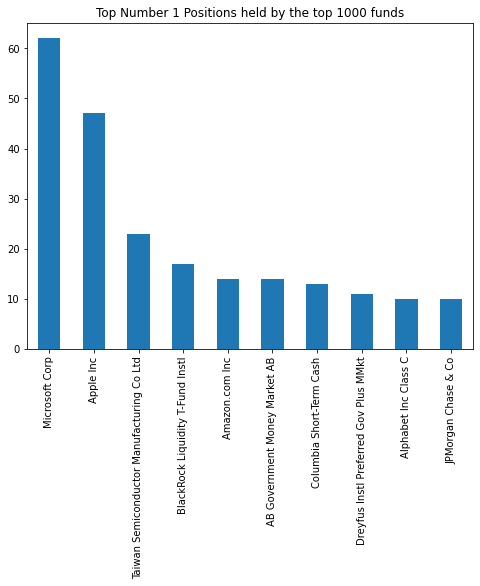

In [31]:
top1_vals = df_best_1000_top1['top_holding'].value_counts()#Provide a pandas series of the counts for each holding

# The below should be a bar chart of the proportion of the top 10 most frequent holdings in the number 1 spot

plt.figure(figsize=(8,6))
(top1_vals[:10]).plot(kind="bar");
plt.title("Top Number 1 Positions held by the top 1000 funds");


In [32]:
# display the counts
top1_vals.head(10)

Microsoft Corp                               62
Apple Inc                                    47
Taiwan Semiconductor Manufacturing Co Ltd    23
BlackRock Liquidity T-Fund Instl             17
Amazon.com Inc                               14
AB Government Money Market AB                14
Columbia Short-Term Cash                     13
Dreyfus Instl Preferred Gov Plus MMkt        11
Alphabet Inc Class C                         10
JPMorgan Chase & Co                          10
Name: top_holding, dtype: int64

Taiwan Semiconductor Manufacturing Co Ltd moved up further in the ranking of top holdings when I drilled into only the number 1 holdings (top_1) indicating that nearly half of Taiwan Semiconductor Manufacturing Co Ltd's appearances in the top list for top holdings of the 1000 best performing funds over 1 year are as the top holding of the respective funds. Definitely an company worth keeping an eye on going forward.

## 6. Question No. 3: Predicting Fund Performance<a name="item6"></a>
<a href="#itemA">*`Table of content`*</a>


I wanted to explore if the following variables could be used to predict a fund's year to date return:

***Predictor variables:***
1. The Morningstar return rating (column - `morningstar_return_rating`): Morningstar is a research firm and data provider and their ratings are considered by fund investors when evaluating the quality of a fund. I would expect higher Morningstar ratings to translate to better performance hence this variable may have some predictive value
2. The fund's past performance (column - `fund_mean_annual_return_5years`). Past performance is generally not necessarily considered an indicator of future performance. However, performance over a longer period such has 5 years may have some predictive value as it may provide a measure of the fund manager skill without being overweighed by the most recent performance as may be the case with the 1 year return
3. The fund investment style (column - `investment_type`): The investment style (blend, growth, value) is inherently a differentiation in the investment approach and I expect this to also some of the variation in performance
4. The fund size category (column - `size_type`): Given the different risk profiles of companies in the large, medium and small size categories I would expect this to affect their return profiles hence this variable may explain some of the variation between funds targeting difference size category  

***Dependent variable:***

I will use the year-to-date fund return (column - `fund_return_ytd`) as the dependent variable as this is the most recent performance metric that also covers a period close to 1 year and is a measure that investors will track to monitor their holdings or may consider in making decisions about whether to buy, hold or sell their position in a given fund

***Other variable:***

We will also include the `category_return_5years` column as this will be used for imputation later

In [33]:
# specify dependendent variable (fund_return_ytd) and explanatory variables


xy_cols = ['fund_return_ytd','morningstar_return_rating', 'category_return_5years', 
           'fund_mean_annual_return_5years', 'investment_type', 'size_type']

df_xy = df1[xy_cols]

# drop all columns without a ytd return as this is value that we need to predict
df_xy = df_xy.dropna(subset=['fund_return_ytd'], axis=0)

 
print('There are {} rows in the dataset to be used for predictive modelling'.format(df_xy.shape[0]))


There are 23353 rows in the dataset to be used for predictive modelling


In [34]:
# show the percentage of columns with values (not null)

null_percentage = lambda x: 1 - x.isnull().mean()

print('{}'.format(df_xy.apply(null_percentage) * 100))

fund_return_ytd                   100.000000
morningstar_return_rating          93.623946
category_return_5years             96.291697
fund_mean_annual_return_5years     88.977862
investment_type                    95.897743
size_type                          95.897743
dtype: float64


In [35]:
df_xy['size_type'].value_counts()


Large     13009
Medium     5523
Small      3863
Name: size_type, dtype: int64

In [36]:
df_xy['investment_type'].value_counts()

Blend     10723
Value      6798
Growth     4874
Name: investment_type, dtype: int64

It is not possible to impute values for the investment_type or size_type. If this information is not available there is no reasonable way of estimating what the values may be without assigning some random value. We will therefore drop all the columns that have missing data in these columns

In [37]:
df_xy = df_xy.dropna(subset=['investment_type', 'size_type'], how='any', axis=0)

print('There are {} rows remaining in the dataset'.format(df_xy.shape[0]))


There are 22395 rows remaining in the dataset


###  6a -  Convert investment type and size type from categorical to numeric variable<a name="item6a"></a>
<a href="#itemA">*`Table of content`*</a> 



The `investment_type` and `size_type` are categorical columns which can not be used in a simple linear regression model. We will convert these to numeric values using one-hot encoding

We first create a function `create_dummy_df` that creates dummy variables for all categorical columns and removes the original column


In [38]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), \
                            pd.get_dummies(df[col], prefix=col, prefix_sep='_', \
                                           drop_first=False, dummy_na=dummy_na)], axis=1)
        except:
            continue
        
    return df

In [39]:
# Create a list of the column names of the categorical variables
cat_cols_lst = ['investment_type', 'size_type']

#Use function above to convert from categorical to numeric columns
df_xy = create_dummy_df(df_xy, cat_cols_lst, dummy_na=False)

# Show shape to assure it has shape of (22395, 10) - i.e. 6 original less 2 categorical plus 6 new dummy variable
print(df_xy.shape)

(22395, 10)


In [40]:
df_xy.columns

Index(['fund_return_ytd', 'morningstar_return_rating',
       'category_return_5years', 'fund_mean_annual_return_5years',
       'investment_type_Blend', 'investment_type_Growth',
       'investment_type_Value', 'size_type_Large', 'size_type_Medium',
       'size_type_Small'],
      dtype='object')

###  6b -  Imputation for fund_mean_annual_return_5years<a name="item6b"></a>
<a href="#itemA">*`Table of content`*</a> 




We will use the following logic to impute the missing values for the `fund_mean_annual_return_5years` column:
1. Use the `category_return_5years` value, if available. This will need to be annualized to make it comparable with the `fund_mean_annual_return_5years` column
2.

In [41]:
# variables for the two columns to make it easier to write the columns in the following cells
col1 = 'fund_mean_annual_return_5years'
col2 = 'category_return_5years'

# loop through each row in the 5year return column and assign the annualized category 5 year return if value is NaN
for i in df_xy[col1].index:
    if pd.isnull(df_xy[col1][i]) == True and pd.isnull(df_xy[col2][i]) != True:
        df_xy.loc[i,col1] = df_xy.loc[i, col2]/5

# calculate percentage of non-missing values
no_null_percent = (1 - df_xy[col1].isnull().mean()) * 100

# display percentage
print('The percentage of rows with values in the {} column is {:.2f}%'.format(col1, no_null_percent))


The percentage of rows with values in the fund_mean_annual_return_5years column is 99.15%


99.15% completeness percentage is good enough so will drop the remaining rows and also drop the `category_return_5years` column as we are done using it for imputing the values to the `fund_mean_annual_return_5years` column

In [42]:
# drop rows the remaining 0.85% of rows that still have missing values in the fund return column
df_xy = df_xy.dropna(subset=[col1], how='any', axis=0)

# drop the category return column now that it has been used for imputation
df_xy.drop('category_return_5years', axis=1, inplace=True)

# display the remaining number of records available for modelling
print('There are {} rows remaining in the dataset'.format(df_xy.shape[0]))

There are 22204 rows remaining in the dataset


In [43]:
# print percentage of rows with values to show that only the morningstar_return_rating remains incomplete 
print('{}'.format(df_xy.apply(null_percentage) * 100))

fund_return_ytd                   100.000000
morningstar_return_rating          94.802738
fund_mean_annual_return_5years    100.000000
investment_type_Blend             100.000000
investment_type_Growth            100.000000
investment_type_Value             100.000000
size_type_Large                   100.000000
size_type_Medium                  100.000000
size_type_Small                   100.000000
dtype: float64


###  6c -  Preparation for the morningstar_return_rating variable<a name="item6c"></a>
<a href="#itemA">*`Table of content`*</a> 

We will used the K-nearest neighbor (KNN) machine learning model to impute the missing values for the `morningstar_return_rating` column

In [44]:
# first normalize the data using the MinMaxScaler from scikit-learn
scaler = MinMaxScaler()
df_xy = pd.DataFrame(scaler.fit_transform(df_xy), columns = df_xy.columns)
df_xy.head()

,fund_return_ytd,morningstar_return_rating,fund_mean_annual_return_5years,investment_type_Blend,investment_type_Growth,investment_type_Value,size_type_Large,size_type_Medium,size_type_Small
0,0.665390,0.50,0.473520,0.0,0.0,1.0,1.0,0.0,0.0
1,0.647699,0.50,0.551402,1.0,0.0,0.0,1.0,0.0,0.0
2,0.697458,0.75,0.658879,0.0,1.0,0.0,1.0,0.0,0.0
3,0.611146,0.75,0.537383,1.0,0.0,0.0,1.0,0.0,0.0
4,0.660534,0.75,0.524922,1.0,0.0,0.0,1.0,0.0,0.0


In [45]:
# instatiate the imputer with 5 clustes given the morningstar rating is from 1 to 5
imputer = KNNImputer(n_neighbors=5)

# generate updated dataframe with imputed values for missing values
df_xy = pd.DataFrame(imputer.fit_transform(df_xy),columns = df_xy.columns)

In [46]:
# print percentage of rows with values to show all columns are now 100% complete 
print('{}'.format(df_xy.apply(null_percentage) * 100))

fund_return_ytd                   100.0
morningstar_return_rating         100.0
fund_mean_annual_return_5years    100.0
investment_type_Blend             100.0
investment_type_Growth            100.0
investment_type_Value             100.0
size_type_Large                   100.0
size_type_Medium                  100.0
size_type_Small                   100.0
dtype: float64


In [47]:
#df_xy.isna().any()
#df_xy.isna().sum()

###  6d -  Build and test the model<a name="item6d"></a>
<a href="#itemA">*`Table of content`*</a> 

In [48]:
# display columns
df_xy.columns

Index(['fund_return_ytd', 'morningstar_return_rating',
       'fund_mean_annual_return_5years', 'investment_type_Blend',
       'investment_type_Growth', 'investment_type_Value', 'size_type_Large',
       'size_type_Medium', 'size_type_Small'],
      dtype='object')

In [49]:
#Split into explanatory and response variables
X_cols = ['morningstar_return_rating', 'fund_mean_annual_return_5years', 
          'investment_type_Blend', 'investment_type_Growth', 'investment_type_Value', 
          'size_type_Large', 'size_type_Medium', 'size_type_Small']

X = df_xy[X_cols]

y = df_xy['fund_return_ytd']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test)

#Display results
print("The training sample included {} records out of the total available of {}".format(len(y_train),len(df_xy)))
print("\n")
print("The r-squared score for the model was {} on {} test values.".format(r2_score(y_test, y_test_preds), len(y_test)))

The training sample included 15542 records out of the total available of 22204


The r-squared score for the model was 0.2842043137808977 on 6662 test values.


###  6e -  Conclusion<a name="item6e"></a>
<a href="#itemA">*`Table of content`*</a> 

With an **r-square score** of **0.28** on the test data, the model provides some explanation of the variation in current performance but it is not high enough to be considered very useful for prediction. Perhaps with some addition of other features the model may be improved upon, but for now we leave it here.